### Overview

This tutorial demonstrates how to use Longcell to analyze single cell isoform count data. Due to the frequent truncations in Nanopore long reads sequencing and to allow for identification of new ioforms, Longcell stores the isoform information as sequence of splicing sites. So instead of building a cell-by-isoform matrix, Longcell reveal alternative splicing events on the splicing sites level. But the cell-by-isoform matrix is also provided for regular single cell RNA seq analysis,like cell type clustering. 

The general steps for the analysis are:

1. regular scRNA-seq gene/isoform expression analysis.

2. identify highly variable splicing sites.

3. differetial alternative splicing analysis between cell groups

First, we load Longcell and the other packages necessary for this vignette.

In [1]:
options(future.globals.maxSize= 1024*1024^2)

In [2]:
library(Longcell)
library(Seurat)
library(dplyr)
library(future)
library(future.apply)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### annotation

The gene strand information is necessary to build meta splicing sites in the downstream analysis, here we can use the `gene_bed.rds` output from the LongcellPre package, but you can also use your annotation file to indicate the gene strand information. It should be a table with at least two columns, one for the gene name, and the other one for the gene strand.

In [3]:
gene_bed = readRDS("../inst/extdata//annotation//gene_bed.rds")

### data overview

Here we are using the sample of colorecatal metastasis to liver published in our paper as an example. The single cell isoform quantification for this sample is generated by LongcellPre.

We can generate a Seurat object based on the cell by isoform matrix, just in the same way as the cell by gene matrix.

In [126]:
iso_mat = Read10X("../inst/extdata/data/isoform/",gene.column = 1)

In [128]:
crc = CreateSeuratObject(counts = iso_mat,project = "isoform",min.cells = 3,min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [129]:
crc

An object of class Seurat 
17767 features across 236 samples within 1 assay 
Active assay: RNA (17767 features, 0 variable features)
 1 layer present: counts

We can first do general single cell analysis via regular Seurat process to get the cell cluster information

In [130]:
suppressWarnings({
    crc <-  crc %>%
    SCTransform(method = "glmGamPoi", verbose = FALSE) %>%
    RunPCA(npcs = 30, verbose = FALSE) %>%
    RunUMAP(reduction = "pca", dims = 1:20,n.neighbors = 30,verbose = FALSE)
})

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



Here we directly use the cell type annotation we get from marker genes to annotate cell clusters.

In [131]:
cell_type = read.table("../inst/extdata/data/cell_type.txt",header = TRUE)
rownames(cell_type) = cell_type$cell
crc$type = cell_type[colnames(crc),"type"]

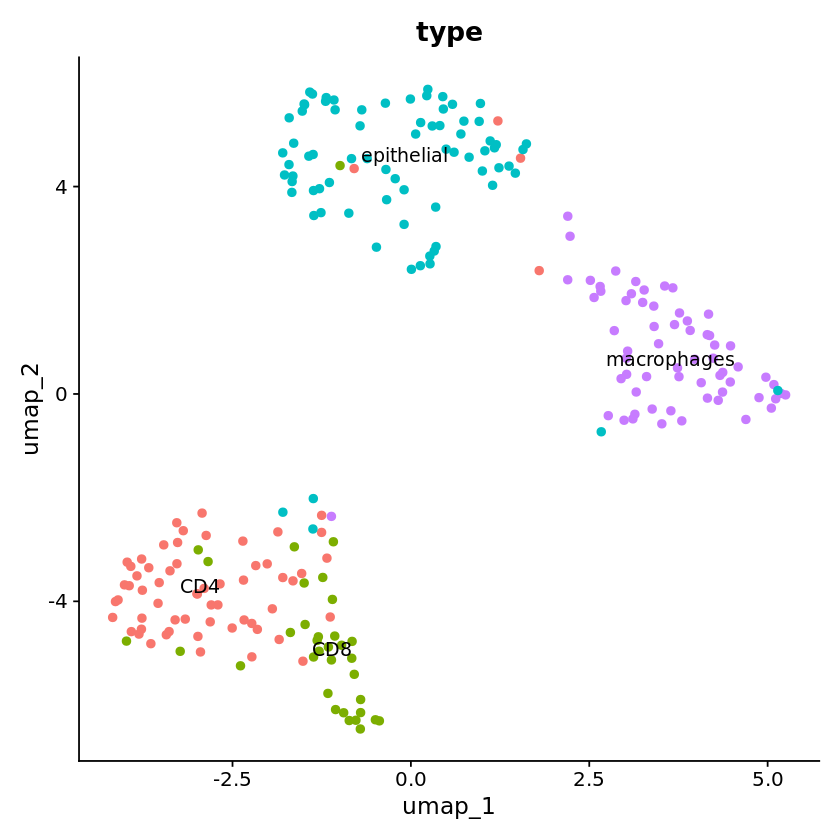

In [10]:
DimPlot(crc, reduction = "umap", group.by = "type",label = TRUE,pt.size = 2)+NoLegend()

### Single cell heterogeneity of alterative splicing

After we take a glance on the data, we can start to explore the alternative splicing within the cell population. Longcell detect the alternative splicing event at the splice site level.We first read in the data for the downstream analysis.

In [11]:
iso = readRDS("../inst/extdata/data/sc_iso_count.rds")

Each read here is stored as $s_1,e_1|s_2,e_2|...$, in which $s_i$ means the start position of the exon $i$ while $e_i$ means the end position.

We first build a Splice object based on this data.

In [12]:
crc_splice = creatSplice_from_df(iso)

The isoform sequences and expression can be revisted from the Splice object by `getIsoform()`

In [13]:
temp = getIsoform(crc_splice,c("MYL6","RPS24"))

In [14]:
head(temp)

,cell,gene,isoform,count,polyA
,<chr>,<chr>,<chr>,<dbl>,<dbl>
575755,AAACGGGGTTATGTGC,RPS24,"78033859,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040615,78040692",0.1904762,1.0000000
575756,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78035580",0.3333333,0.0000000
575757,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040694",3.3333333,0.9914286
575758,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040695",1.3333333,1.0000000
575759,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040696",1.6666667,0.9898305
575760,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040697",6.0000000,0.9949483


As isoform count is even sparser than the gene count, we can only get confident alternative splicing signals from high expression genes, thus we can filter out lowly expressed genes to save the computing time.

In [15]:
heg = HighExprsGene(crc_splice,thresh = 500)
head(heg)
length(heg)

[1] "ABRACL" "ACTB"   "ACTG1"  "ACTN4"  "AGR2"   "AIF1"

[1] 752

Here 752 genes would be preserved for downstream $\phi$ calculation. And before that, we can first merge splicing sites which are always coexisting or mutually exclusive as meta splicing sites, as they contain the same information. Through this step we can further decrease the computation burden. The parameter `eps` can be adjusted to indicate how aggressive the merging process would be.Higher `eps` leads to more aggressive merge, but may be more possible to lead to information loss.

In [136]:
plan(strategy = "multisession",workers = 8)
crc_splice = geneSiteTable(crc_splice,gene_bed,genes = heg,eps = 0.05)

The merged splicing sites are saved in a `metaSite` object, for example:

In [18]:
getMetaSites(crc_splice,"MYL6")

metaSite object with  225  cells and  4 meta splicing sites, which are merged from  25 original splicing sites.
The head of the gene count matrix for each meta site is:
                 metasite_1 metasite_2 metasite_3 metasite_4
AAACGGGGTTATGTGC         29         28         29         29
AACCATGAGCCACGCT          5          4          5          5
AACCATGCAAGCCTAT          6          5          5          5
AACTCTTCAAGTAATG          3          2          3          2
AAGACCTAGCTGAAAT          2          1          2          2
AAGACCTTCAAACGGG         12          9         12         12
The head of the spliced in count matrix for each meta site is:
                 metasite_1 metasite_2 metasite_3 metasite_4
AAACGGGGTTATGTGC         29         28         29          2
AACCATGAGCCACGCT          5          4          5          0
AACCATGCAAGCCTAT          6          5          5          0
AACTCTTCAAGTAATG          3          2          2          2
AAGACCTAGCTGAAAT          2         

The `metaSite` object maintains two matrices, one records the gene count for each meta splice site and the other records the spliced-in count. The correspondence between the meta sites and original sites is also recorded in it.

After we generate the meta splicing sites, we can estimate the ratio of inter-cell heterogeneity for each meta site.

In [19]:
plan(strategy = "multisession",workers = 8)
crc_phi = genesSitesPhi.base(crc_splice,genes = heg,method = "beta",verbose = FALSE)

Each row in the result table records the $\bar{\psi}$ (percent-spliced-in) and $\phi$ (inter-cell heterogeneity) estimation and the confidence interval for $\phi$. The count `column` means the number of cells which have valid gene expression to estimate the $\psi$ and $\phi$.

In [20]:
head(crc_phi)

,gene,meta_sites,mean_psi,phi,phi_lwr,phi_upr,count,phi_conf
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AGR2,metasite_2,0.7553166,0.05558393,-0.007364070,0.1185319,20,0.1258960
2,ANAPC11,metasite_2,0.4206358,0.15273095,0.060189270,0.2452726,28,0.1850834
3,ANAPC11,metasite_6,0.4774544,0.14312845,0.050723033,0.2355339,28,0.1848108
4,AREG,metasite_2,0.8635209,0.10122846,0.002846471,0.1996104,23,0.1967640
5,ATF3,metasite_6,0.7075183,0.13312699,0.040007757,0.2262462,21,0.1862385
6,BCL2A1,metasite_2,0.1698188,0.09520912,0.021722143,0.1686961,32,0.1469739


We can then show all valid $\phi$ estimation with small confidence interval in a $\phi$ vs. $\bar{\psi}$ scatter plot

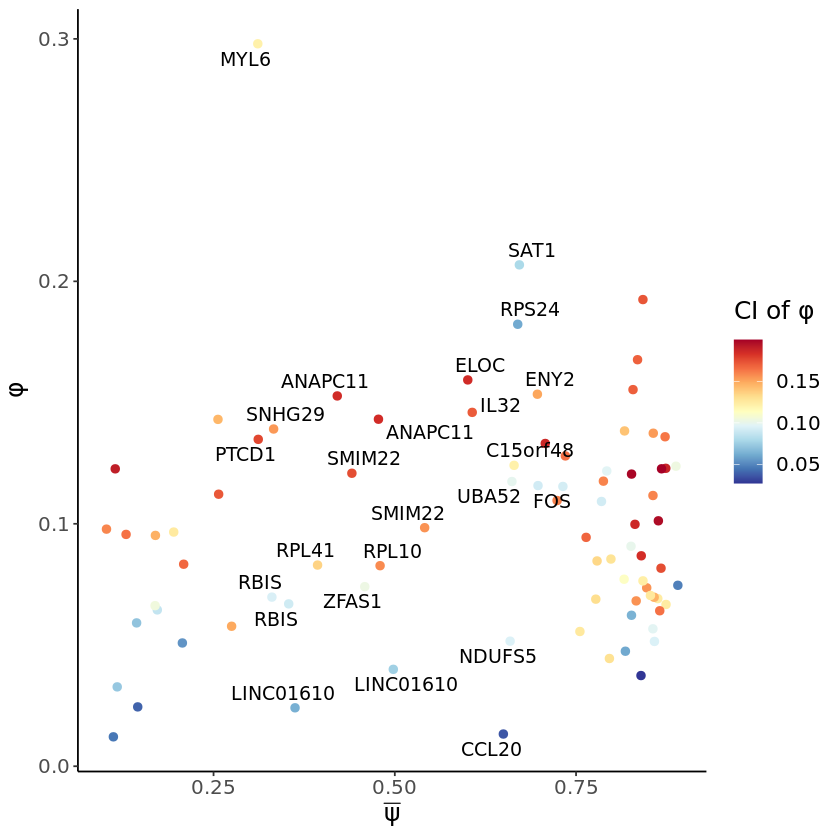

In [21]:
phiPlot(crc_phi,annot_col = "gene")

We could order the $\phi$ for each meta splicing site in a decreasing order, and the top list should be highly variable exons.

In [22]:
head(crc_phi[order(crc_phi$phi,decreasing = TRUE),])

,gene,meta_sites,mean_psi,phi,phi_lwr,phi_upr,count,phi_conf
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,MYL6,metasite_4,0.3110294,0.2979716,0.23732462,0.3586186,111,0.12129397
66,SAT1,metasite_3,0.6718207,0.2067908,0.16702254,0.2465591,157,0.07953661
25,IER3,metasite_2,0.8422321,0.1924780,0.10616716,0.2787887,53,0.17262158
63,RPS24,metasite_3,0.6695511,0.1822913,0.15178788,0.2127947,221,0.06100680
74,SNHG6,metasite_2,0.8348119,0.1676768,0.08307809,0.2522754,44,0.16919734
16,ELOC,metasite_4,0.6006515,0.1593375,0.06683127,0.2518437,34,0.18501247


Here we use the highest one MYL6 metasite_4 as an example, we could first show its single cell $\psi$ distribution,the color of the bar indicates the average gene expression:

In [19]:
gene = "MYL6"
site = "metasite_4"

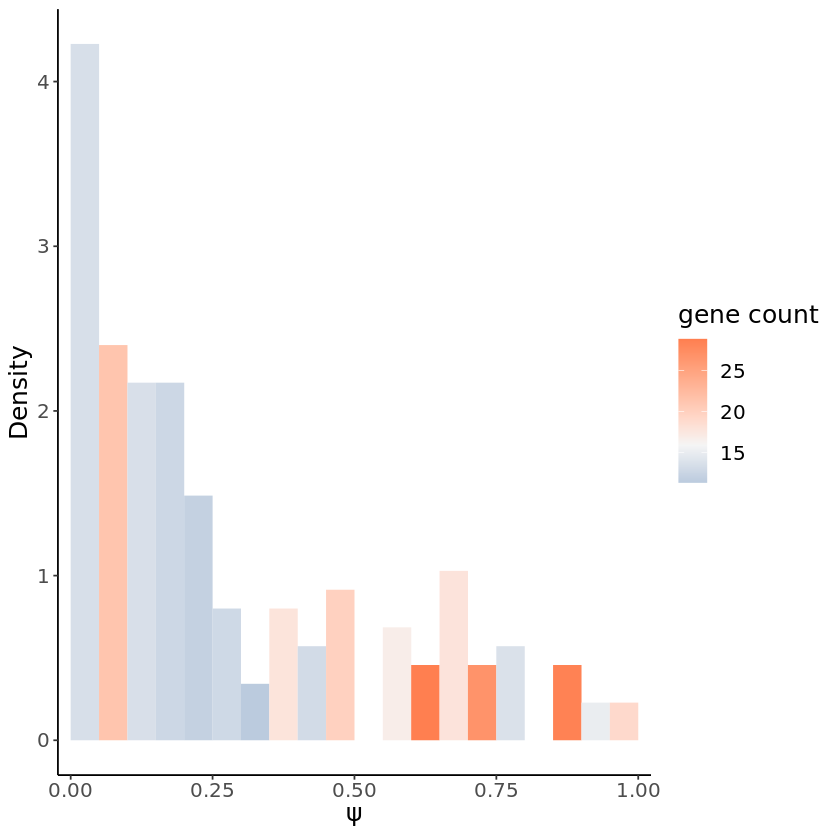

In [24]:
psiHist(crc_splice,gene = gene,site = site)

We could also show the $\psi$ distribution in the cell embedding umap:

In [17]:
embedding = as.data.frame(crc@reductions$umap@cell.embeddings)

[[1]]


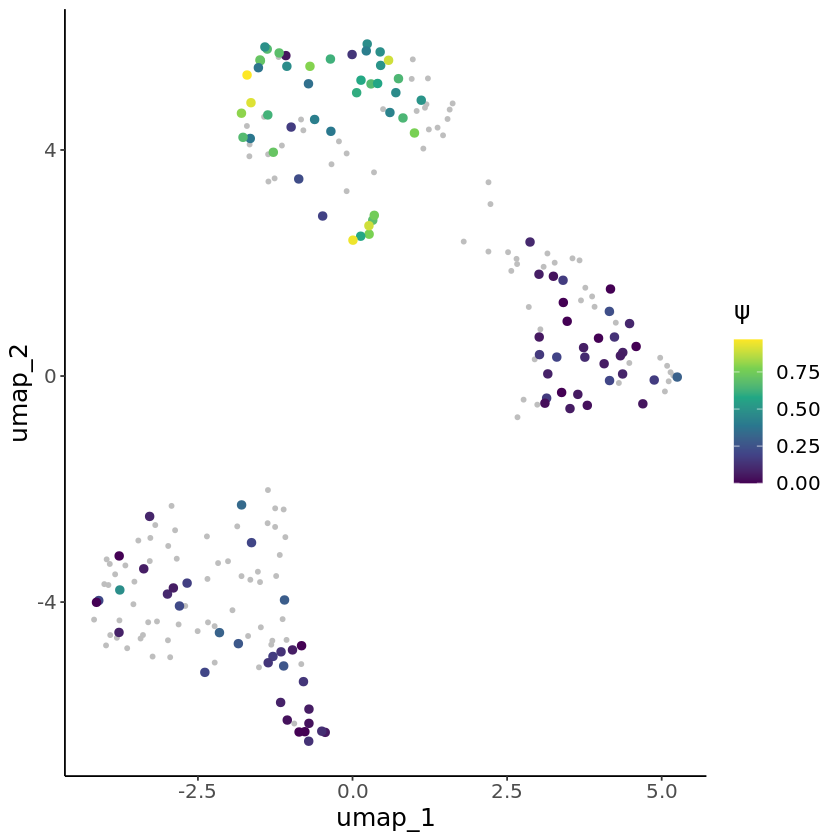

In [20]:
psiCellPlot(crc_splice,gene = gene,site = site,cell_embedding = embedding)

We could see very different alternative splicing patterns for this exon in epithlials and other immune cells. Epithlials highly spliced in the metasite_4 in MYL6, while T cells and macrophages tend to splice this meta site out.

If we trace back to the original sites, we could find that the metasite_4 contains two sites:

In [27]:
getMetaSites(crc_splice,"MYL6")@sites

[[1]]
 [1] "56158404_out" "56158415_out" "56158684_in"  "56158711_out" "56158902_in" 
 [6] "56158920_out" "56159498_in"  "56159587_in"  "56159622_out" "56159975_in" 
[11] "56160025_in"  "56160055_out" "56160148_out" "56160243_in"  "56160284_out"
[16] "56161465_out" "56161547_in"  "56162264_in"  "56162331_out" "56162855_in" 

[[2]]
[1] "56159730_out"

[[3]]
[1] "56160320_out" "56161387_in" 

[[4]]
[1] "56160626_in"  "56160670_out"

We can compare the sashimi plot between the epithlials and the immune cells group to see which exons are differetially spliced between the two cell groups.

In [21]:
epithlials = colnames(crc)[crc$type == "epithelial"]
immune = colnames(crc)[crc$type != "epithelial"]

Warning message:
“Removed 1009 rows containing missing values (`geom_segment()`).”


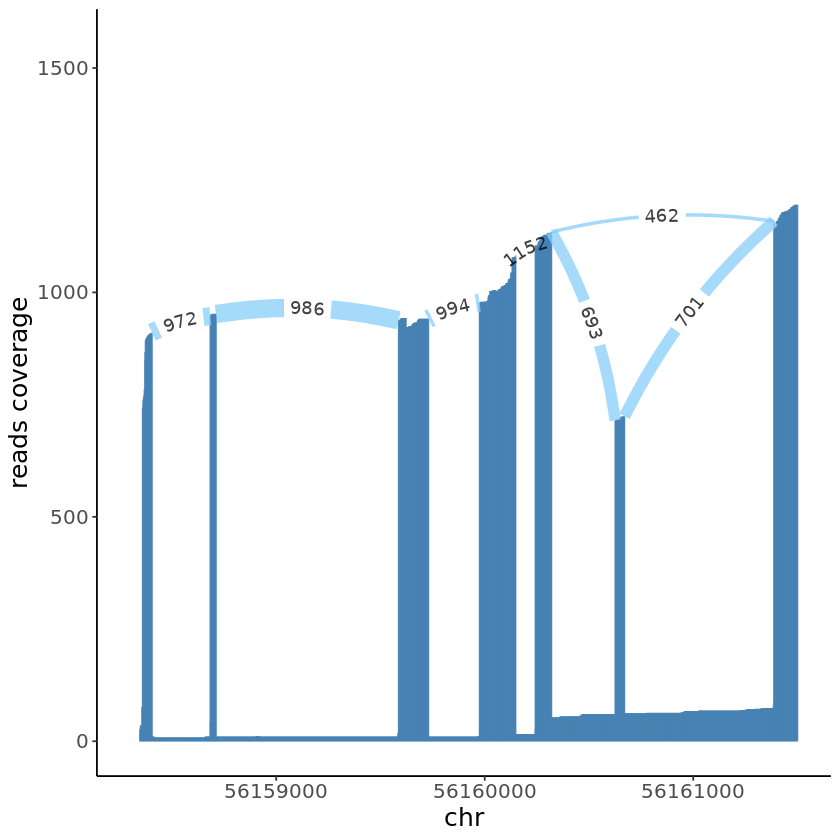

In [29]:
sashimi(crc_splice,gene = "MYL6",cells = epithlials)+xlim(c(56158300,56161500))

Warning message:
“Removed 1719 rows containing missing values (`geom_segment()`).”


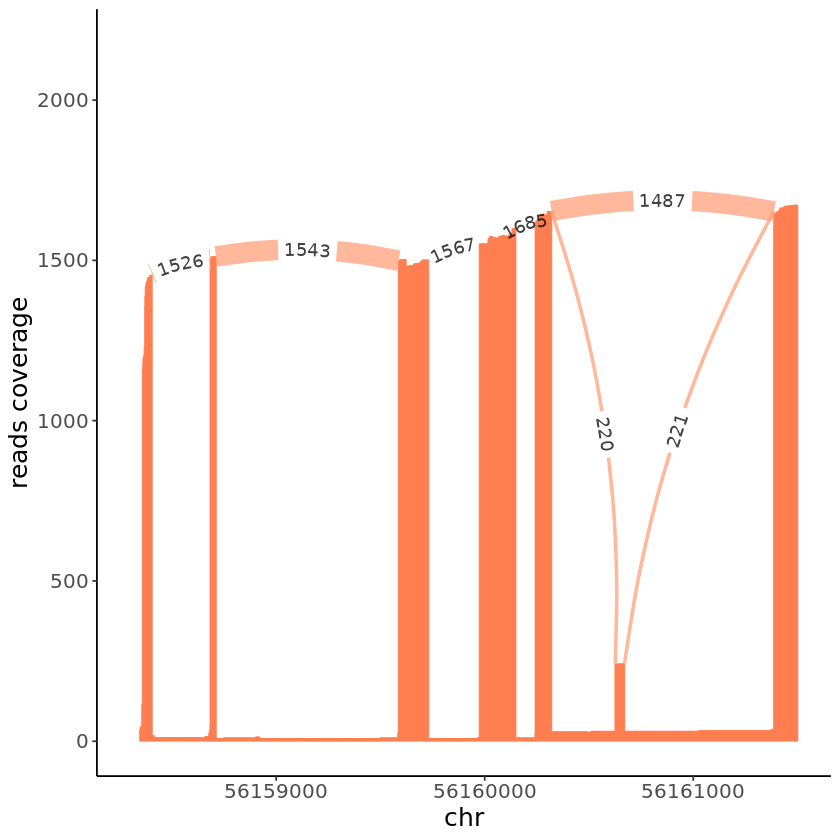

In [30]:
sashimi(crc_splice,gene = "MYL6",cells = immune,color_id = 2)+xlim(c(56158300,56161500))

From the sashimi plot we can see that the exon $6$ has differetial alternative splicing between the epithlials and immune cells.

### Generalized Likelihood Ratio Test

Since we have found the splicing heterogeneity between epithelials and immune cells, here we could do a differential alternative splicig analysis between the two cell groups to see if they have other more splicing difference.

Still, we would do generalized likelihood ratio test for highly expressed genes.

In [31]:
plan(strategy = "multisession",workers = 8)
group1 = list(epithlials)
group2 = list(immune)
names(group1) = "epithlials"
names(group2) = "immune"
crc_GLRT_sig = genes_groups_GLRT(crc_splice,genes = names(crc_splice@meta_sites),
                              group1s = list(epithlials),group2s = list(immune))

[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current starting points doesn't converge, will try other starting points!"
[1] "The MLE based on current 

In [32]:
head(crc_GLRT_sig[order(crc_GLRT_sig$q),])

,gene,group1,group2,site,p,alpha1,beta1,alpha2,beta2,q,mean_diff,var_diff
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
346,RPS24,1,1,metasite_3,4.594592e-28,15.4360341,2.3924591,4.4251506,3.2491754,2.991079e-25,-0.28918950,0.021973232
401,MYL6,1,1,metasite_4,2.648065e-26,2.5928891,2.1799853,1.8689681,11.1277555,8.619453e-24,-0.39945223,-0.034185268
388,PCBP2,1,1,metasite_3,1.155557e-10,0.8140863,0.5537612,20.2299469,32.2189723,2.507559e-08,-0.20945105,-0.097323939
255,SSBP1,1,1,metasite_1,4.206488e-10,12.6321858,4.5543177,0.5988598,0.2118594,6.846059e-08,0.00367108,0.095896102
485,SERF2,1,1,metasite_2,1.029698e-08,2.5073500,15.8760372,1.1045116,17.8989193,1.340666e-06,-0.07827047,-0.003340111
252,ENSG00000284292,1,1,metasite_2,9.758362e-07,0.9610742,0.7389297,3.9540248,0.6311182,1.058782e-04,0.29701938,-0.069758906


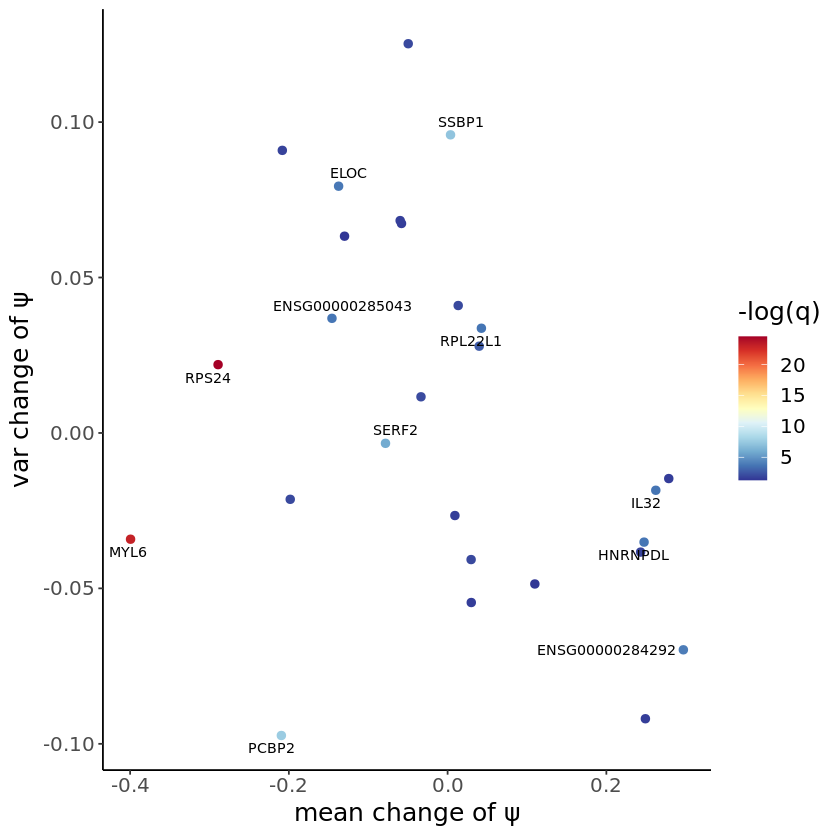

In [33]:
GLRT_sig_plot(crc_GLRT_sig)

The metasite_4 in MYL6 is one of the most significant result in the differential alternative splicing analysis between the immune and epithelial cells, which follows our expectation. As from last section, we do observe obvious inter-cell heterogeneity for this metasite.

Besides MYL6, there also other metasites show siginificant difference. For example, the metasite_3 in RPS24, we can observe its $\psi$ distribtion in two cell populations as a sanity check.

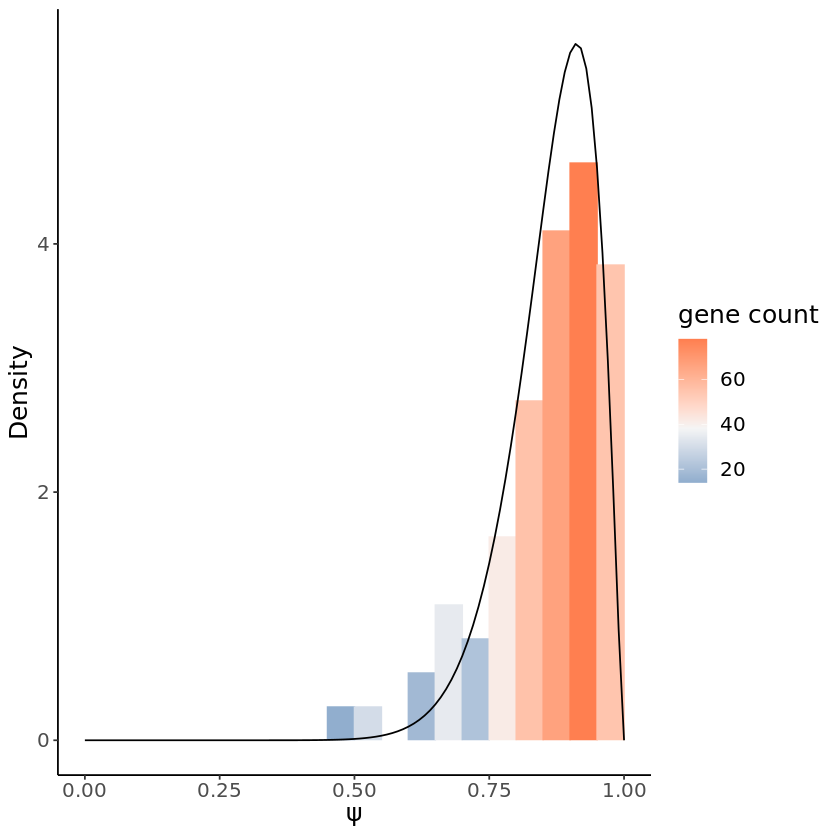

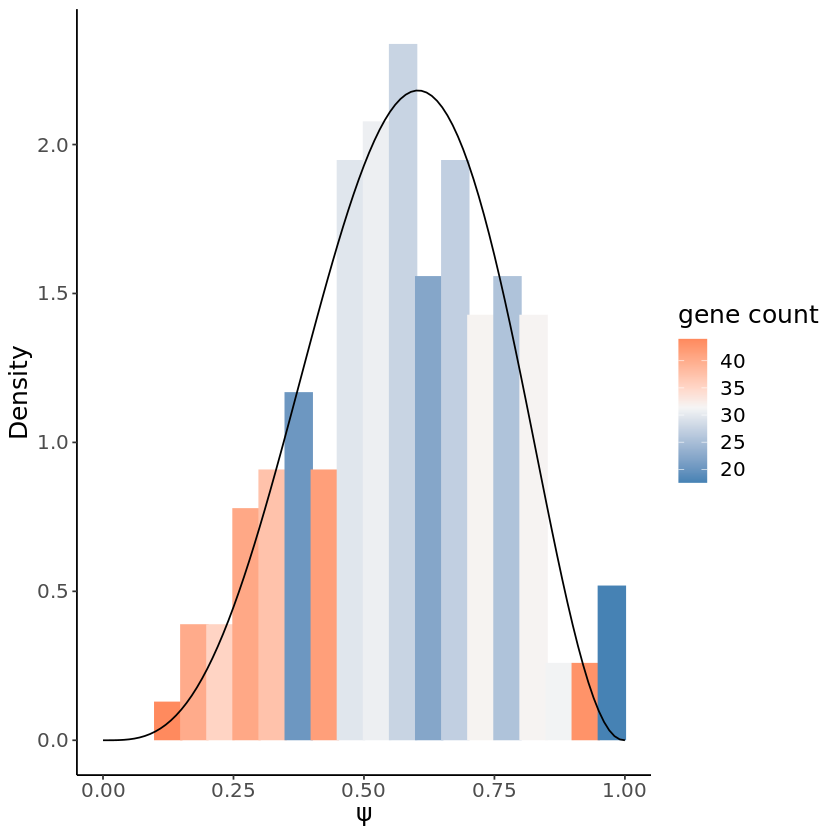

In [34]:
psiHist(crc_splice,gene = "RPS24",site = "metasite_3",cells = epithlials,
        alpha = 15.4360341,beta = 2.3924591)
psiHist(crc_splice,gene = "RPS24",site = "metasite_3",cells = immune,
        alpha = 4.4251506,beta = 3.2491754)

From above histogram we do see, compared to the immune cells, RPS24 in epthelial preserved more metasite_3.

In [24]:
getMetaSites(crc_splice,"RPS24")@sites

[[1]]
 [1] "78033904_out" "78033986_out" "78034232_in"  "78034316_out" "78034421_out"
 [6] "78035352_in"  "78035417_out" "78035511_in"  "78035646_in"  "78037219_in" 
[11] "78037290_out" "78037965_in"  "78037982_out" "78040629_in"  "78040647_in" 

[[2]]
[1] "78035720_out" "78037194_in"  "78037304_out" "78040615_in" 

[[3]]
[1] "78040204_in"  "78040225_out"

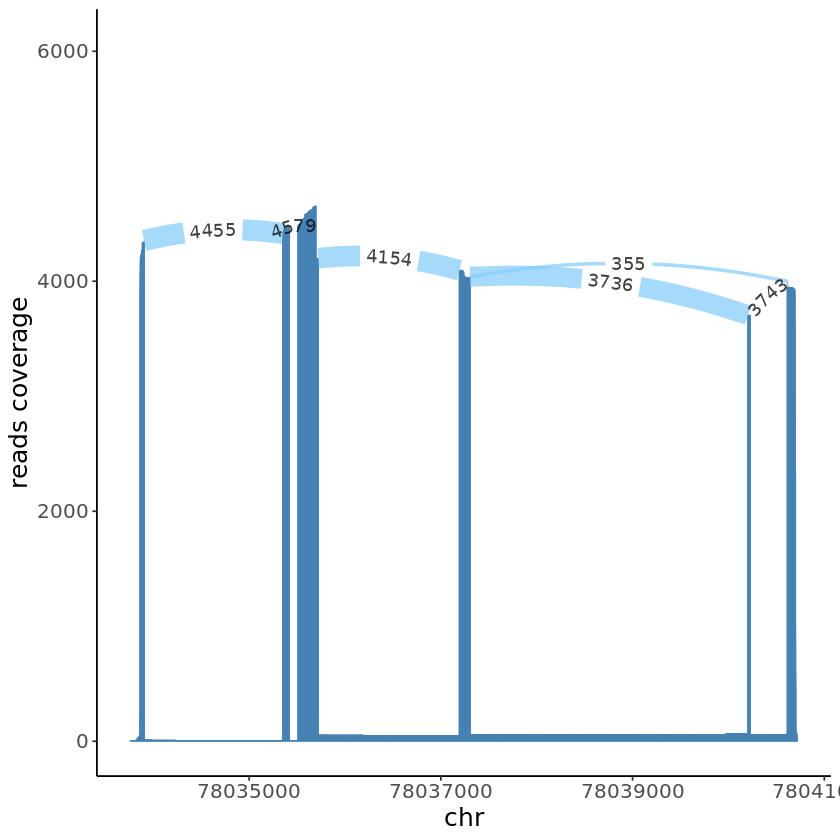

In [22]:
sashimi(crc_splice,gene = "RPS24",cells = epithlials)

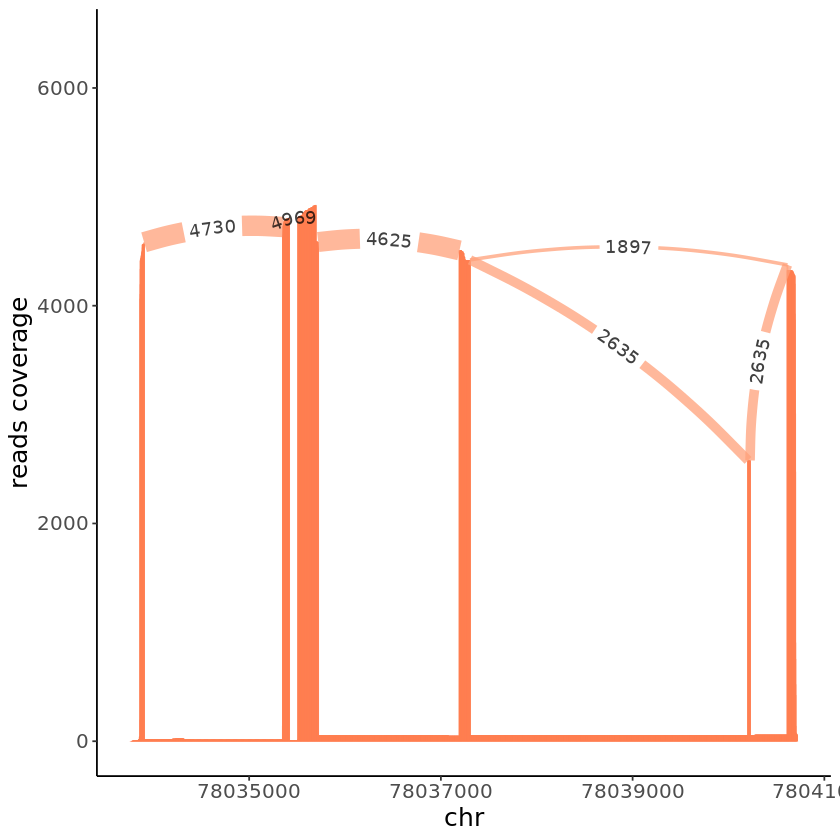

In [23]:
sashimi(crc_splice,gene = "RPS24",cells = immune,color_id = 2)